# PDM Microphone Simulation
This notebook holds a simulation of how to process a PDM signal from a MEMS microphone. 

To read more about MEMS microphones look at the following series of articles
1. Wikipedia: https://en.wikipedia.org/wiki/Pulse-density_modulation
1. Into to MEMs Mics: https://curiouser.cheshireeng.com/2014/10/21/introduction-to-mems-microphones/
1. Using a PDM Mic: https://curiouser.cheshireeng.com/2014/11/04/using-a-pdm-microphone/
1. PDM on ATTiny85 MCU: https://curiouser.cheshireeng.com/2015/01/16/pdm-in-a-tiny-cpu/
1. Source Code for ATTiny85: https://curiouser.cheshireeng.com/2015/01/21/pdm-in-attiny85-source-code/

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [3]:
def my_fft(x_n, fs, fftlen=-1, shifted=True):
    if fftlen < len(x_n): fftlen = len(x_n)
    x_f = np.fft.fft(x_n, fftlen)
    if shifted:
        f = np.arange(-fs/2, fs/2, fs/fftlen)
        x_f = np.fft.fftshift(x_f)
    else:
        f = np.arange(0, fs, fs/fftlen)
    return (f, x_f)

## Sampling 
The PDM signal is the result of sampling the analog audio signal with a 1-bit ADC. The Catch is that becasue the resolution is 1-bit, we can sample muchfaster then is necessay for audio. Then we can downsamle and average the PDM signal to generate the equvalent PCM signal. 



In [6]:
pcm_fs = 16       #Khz
K_upsample = 64
pdm_fs = K_upsample * pcm_fs  #Khz
sample_time = 1   #ms

pcm_n_samp = sample_time * pcm_fs
pdm_n_samp = K_upsample * pcm_n_samp

## Input Signal
Lets create a test audio signal. I just generated a bunch of random cosine waves and added them together!

In [57]:
pdm_n = np.arange(pdm_n_samp)
pcm_n = np.arange(pcm_n_samp)
#freqs = [0.2, 0.2, 0.76, 1, 1.3, 0.57, 2, 4.3]
freqs = [1]
input_sig = np.zeros(pdm_n_samp)
ex_output = np.zeros(pcm_n_samp)
for f in freqs:
    input_sig += np.sin(2*np.pi*pdm_n*(f/pdm_fs))
    ex_output += np.sin(2*np.pi*pcm_n*(f/pcm_fs))

## Generating the PDM signal 

In [58]:
# see psudocode here: https://en.wikipedia.org/wiki/Pulse-density_modulation
def pcm_to_pdm(x, qe=0, ll=-1,lh=1):
    y = np.zeros(len(x))
    for n in range(0,len(x)):
        qe = qe + x[n]
        if qe > 0: 
            y[n] = lh
        else:
            y[n] = ll
        qe = qe - y[n]
    return y

In [59]:
pdm_sig = pcm_to_pdm(input_sig)
pcm_sig = sp.signal.decimate(pdm_sig, K_upsample)

# Converting to a PCM signal

## Plotting

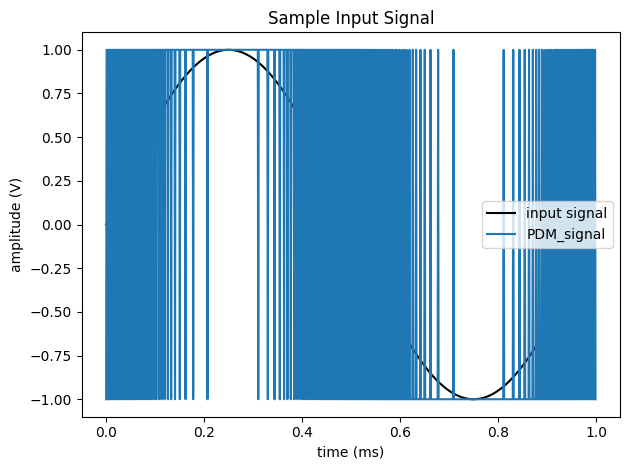

In [60]:
plt.plot(pdm_n/pdm_fs, input_sig, label='input signal', color='k')
#plt.stem(pcm_n/pcm_fs, ex_output, label='expected PCM output')
plt.plot(pdm_n/pdm_fs, pdm_sig, label='PDM_signal')

plt.xlabel('time (ms)')
plt.ylabel('amplitude (V)')
plt.title('Sample Input Signal')
plt.legend()
plt.tight_layout()

## Converting the PDM signal to a PCM (sampled Waveform)
Now we need to decimate the PDM signal to take it from `pdm_fs` down to the desired `pcm_fs`. Decimation falls under the catagory of Multi-rate signal processing which can be a bit complicated. But in general we just want to pass the PCM signal through a Low-Pass (anit-aliasing) filter, and then downsample it by trowing away excess samples. 

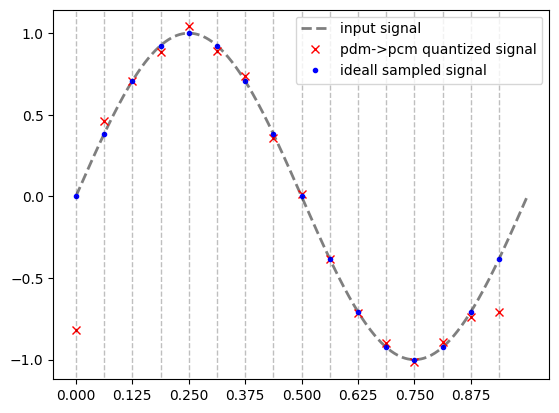

In [61]:
plt.plot(pdm_n/pdm_fs, input_sig, label='input signal', color='k', lw = 2, ls='--', alpha=0.5)
plt.plot(pcm_n/pcm_fs, pcm_sig, label='pdm->pcm quantized signal', linestyle = 'none', marker = 'x', color='r')
plt.plot(pcm_n/pcm_fs, ex_output, label='ideall sampled signal ', linestyle = 'none', marker = '.', color = 'b')
ymin, ymax = (-1.025, 1.025)
xticks = np.arange(0, 1, 1/pcm_fs)
plt.xticks(xticks[0::2])
for x in xticks:
    plt.axvline(x, ymin, ymax, alpha=0.25, c='k', ls='--', lw=1)
#plt.ylim(ymin, ymax)
plt.legend()